# Retrieval Augmented Generation

I will build a RAG system using Pinecone and work with sample dataset of wikipedia  articles and build embeddings out of the articles. Then I will look at what search results look like by doing a simple document retrieval from Pinecone. Then use OpenAi to build a nicely summarized article out of these results. 


![Screenshot 2024-03-28 at 12.30.30 PM.png](<attachment:Screenshot 2024-03-28 at 12.30.30 PM.png>)
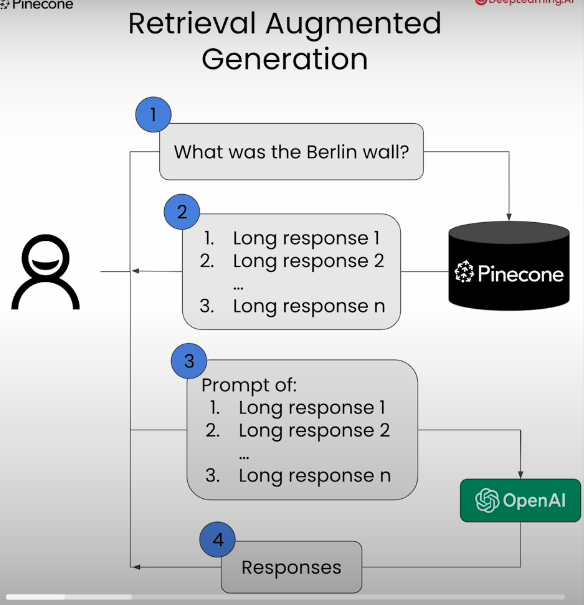

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from datasets import load_dataset
from openai import OpenAI
from pinecone import Pinecone, ServerlessSpec
from tqdm.auto import tqdm
from DLAIUtils import Utils

import ast
import os
import pandas as pd

In [3]:
# Instantiate the Utils class and use it to get the Pinecone API key
utils = Utils()
PINECONE_API_KEY = utils.get_pinecone_api_key()

## Setup Pinecone 

In [4]:
# Connect to Pinecone and create a new index
pinecone = Pinecone(api_key=PINECONE_API_KEY)

utils = Utils()
INDEX_NAME = utils.create_dlai_index_name('dl-ai')
if INDEX_NAME in [index.name for index in pinecone.list_indexes()]:
  pinecone.delete_index(INDEX_NAME)

pinecone.create_index(name=INDEX_NAME, dimension=1536, metric='cosine',
  spec=ServerlessSpec(cloud='aws', region='us-west-2'))

index = pinecone.Index(INDEX_NAME)

## Load the DataSet 

In [5]:
# Access Wiki dataset
# ! unzip ../public/data/lesson2-wiki.csv.zip

**(Note: max_articles_num = 500):** To achieve a more comprehensive context for the Language Learning Model, a larger number of articles is generally more beneficial. In this lab, we've initially set `max_articles_num` to 500 for speedier results, allowing you to observe the outcomes faster. Once you've done an initial run, consider increasing this value to 750 or 1,000. You'll likely notice that the context provided to the LLM becomes richer and better. You can experiment by gradually raising this variable for different queries to observe the improvements in the LLM's contextual understanding.

In [6]:
# Create a data frame (df) from the CSV file containing the Wikipedia articles and use Pandas to read the CSV file
max_articles_num = 500
df = pd.read_csv('./wiki.csv', nrows=max_articles_num)
df.head()

,id,metadata,values
1,1-0,"{'chunk': 0, 'source': 'https://simple.wikiped...","[-0.011254455894231796, -0.01698738895356655, ..."
2,1-1,"{'chunk': 1, 'source': 'https://simple.wikiped...","[-0.0015197008615359664, -0.007858820259571075..."
3,1-2,"{'chunk': 2, 'source': 'https://simple.wikiped...","[-0.009930099360644817, -0.012211072258651257,..."
4,1-3,"{'chunk': 3, 'source': 'https://simple.wikiped...","[-0.011600767262279987, -0.012608098797500134,..."
5,1-4,"{'chunk': 4, 'source': 'https://simple.wikiped...","[-0.026462381705641747, -0.016362832859158516,..."


## Prepare the embeddings and upsert to Pinecone 

In [7]:
prepped = []

# Iterate through dataframe using tqdm and upsert the data to the Pinecone index
for i, row in tqdm(df.iterrows(), total=df.shape[0]):
    # get metadata and pass it through ast package to convert it to a dictionary
		meta = ast.literal_eval(row['metadata'])
    # Append it to the prepped list and create vector embedding with unique id, values, and metadata
		prepped.append({'id':row['id'], 
                    'values':ast.literal_eval(row['values']), 
                    'metadata':meta})
    # Upsert to Pinecone in batches of 250 elements in Pinecone index
		if len(prepped) >= 250:
			index.upsert(prepped)
			prepped = []


  0%|          | 0/500 [00:00<?, ?it/s]

In [8]:
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {},
 'total_vector_count': 0}

## Connect to OpenAI

In [9]:
OPENAI_API_KEY = utils.get_openai_api_key()
openai_client = OpenAI(api_key=OPENAI_API_KEY)

# Helper function to get embeddings from OpenAI; gets an array of text and uses embedding model and returns vector embeddings
def get_embeddings(articles, model="text-embedding-ada-002"):
   return openai_client.embeddings.create(input = articles, model=model)

## Run the query

In [11]:
query = "what is the berlin wall?"

# Create embedding out of that query
embed = get_embeddings([query])
# RUn query against Pinecone index and get top 3 results
res = index.query(vector=embed.data[0].embedding, top_k=3, include_metadata=True)
# Parse the response out, we get back an object from pinecone and extract from the matches object the metadata text
text = [r['metadata']['text'] for r in res['matches']]
print('\n'.join(text))

August 13  1961: Building of the Berlin Wall begins.
 August 14  1945: Japan announces its surrender at the end of World War II.
 August 14/15  1947: India is partitioned at independence from the UK, as the new mainly Islamic state of Pakistan is created.
 August 15  1960: The Republic of the Congo becomes independent.
 August 15  1971: Bahrain becomes independent.
 August 16  1977: Elvis Presley dies aged 42, leading to a worldwide outpouring of grief.
 August 17  1945: Indonesia declares independence from the Netherlands.
 August 17  1960: Gabon becomes independent.
 August 17  1962: Peter Fechter becomes the first person to be shot dead at the Berlin Wall.
 August 19  43 BC: Augustus becomes Roman consul.
 August 19  14: Augustus dies.
 August 19  1919: Afghanistan becomes independent.
 August 19  1991: The August Coup against Mikhail Gorbachev, in the Soviet Union, begins.
 August 20  1940: Leon Trotsky is fatally wounded with an ice pick in Mexico.
 August 20  1968: The Prague Spr

## Prepare a prompt out of the results we just saw from Pinecone 

In [12]:
query = "write an article titled: what is the berlin wall?"
embed = get_embeddings([query])
res = index.query(vector=embed.data[0].embedding, top_k=3, include_metadata=True)

# Build the prompt
# Context is results from Pinecone 
contexts = [
    x['metadata']['text'] for x in res['matches']
]

prompt_start = (
    "Answer the question based on the context below.\n\n"+
    "Context:\n"
)

prompt_end = (
    f"\n\nQuestion: {query}\nAnswer:"
)

# Define a tuple with the prompt start, end, and the contexts
prompt = (
    prompt_start + "\n\n---\n\n".join(contexts) + 
    prompt_end
)

print(prompt)

Answer the question based on the context below.

Context:
August 13  1961: Building of the Berlin Wall begins.
 August 14  1945: Japan announces its surrender at the end of World War II.
 August 14/15  1947: India is partitioned at independence from the UK, as the new mainly Islamic state of Pakistan is created.
 August 15  1960: The Republic of the Congo becomes independent.
 August 15  1971: Bahrain becomes independent.
 August 16  1977: Elvis Presley dies aged 42, leading to a worldwide outpouring of grief.
 August 17  1945: Indonesia declares independence from the Netherlands.
 August 17  1960: Gabon becomes independent.
 August 17  1962: Peter Fechter becomes the first person to be shot dead at the Berlin Wall.
 August 19  43 BC: Augustus becomes Roman consul.
 August 19  14: Augustus dies.
 August 19  1919: Afghanistan becomes independent.
 August 19  1991: The August Coup against Mikhail Gorbachev, in the Soviet Union, begins.
 August 20  1940: Leon Trotsky is fatally wounded wi

## Get the summary from OpenAI

In [13]:
res = openai_client.completions.create(
    model="gpt-3.5-turbo-instruct",
    prompt=prompt,
    temperature=0,
    max_tokens=1500,
    top_p=1,
    frequency_penalty=0,
    presence_penalty=0,
    stop=None
)
print('-' * 80)
print(res.choices[0].text)

--------------------------------------------------------------------------------

The Berlin Wall was a physical barrier that divided the city of Berlin, Germany from 1961 to 1989. It was built by the German Democratic Republic (GDR), also known as East Germany, in an effort to prevent its citizens from fleeing to the democratic West Germany.

The construction of the Berlin Wall began on August 13, 1961, and it consisted of a concrete wall, barbed wire, and guard towers. The wall stretched for 96 miles, dividing the city into two separate parts. The East German government claimed that the wall was built to protect its citizens from Western imperialism and to prevent spies and agents from entering the country.

However, the real purpose of the Berlin Wall was to prevent East Germans from escaping to the West. Before the wall was built, thousands of East Germans had been fleeing to West Germany every day, seeking better economic opportunities and political freedom. The wall effectively c